# Matrix Factorization using Last.fm data

In [1]:
!pip install torch seaborn matplotlib pandas numpy

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import time
import sys

import numpy as np
import pandas as pd

import torch
from torch.distributions import Normal
from torch.nn.functional import softplus

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    env = torch.cuda
    device = torch.device('cuda')
    print("Using GPU")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    env = torch
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [4]:
from aux import *
from aux_plt import *
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [5]:
from losses import *
from log_utility import *

# Configuration

To run standard VI change UTILITY_TERM to "vi".

In [6]:
# optimization general parmeters
SEED = 0
NITER  = 70000 # number of iterations - around 70k is the right number for mininbatch=10
LR = 0.001 # 0.1 is the right number for the full batch, 0.001 advised for mininbatch=10
MINIBATCH = 10 # how many rows of the matrix in minibatch

# model
K = 20 # number of latent variables

# number of samples used to approximate ELBO term
NSAMPLES = 11

# selected loss: tilted/squared 
#  you can also put "exptilted" (that is in [0,1]), but then fix M=1.25
#  and UTILITY_TERM_SCALE=1/1.25 for linearized and UTILITY_TERM_SCALE=1 otherwise
#  also change FIND_H=num-util and EVAL_SKIP_GAIN=False to get an appropriate evaluation
LOSS = "tilted" 
TILTED_Q = 0.2 
# loss-to-utility transformation (bigM: utility=M-loss / id: utility=-loss)
UTIL = "bigM"
M = 10000.0 if UTIL.lower()=="bigm" else 1.0

# constructing an approximation to the utility-dependent term:
UTILITY_TERM = "naive" # vi/naive/linearized/jensen
# the utility-dependent term is multiplied by this value: 
#  should be 1/M for linearized and M for the others
UTILITY_TERM_SCALE = (1.0 if "linearized" in UTILITY_TERM else M)  #for linearized we use U~=-risk 
# how many samples of latent variables
NSAMPLES_UTILITY_TERM_THETA = 31
# how many samples of y for each latent variable
NSAMPLES_UTILITY_TERM_Y = 11
# update gradients of the utility term in every x iterations
UTILITY_TERM_EVERY_NITER = 1

# finding optimal h:
#  analytical - use Bayes estimator / num - optimize numerically gain / 
#  num-util - optimize numerically a selected approximation to the utility-dependent term.
FIND_H = "analytical"
# choose an approximation to the utility-dependent term, by default == UTILITY_TERM
H_UTILITY_AGGREGATOR = UTILITY_TERM
# respectively, the number of theta and y samples used when optimizing for h; 
#  by default the same as for UTILITY_TERM
H_NSAMPLES_UTILITY_TERM_THETA = NSAMPLES_UTILITY_TERM_THETA
H_NSAMPLES_UTILITY_TERM_Y = NSAMPLES_UTILITY_TERM_Y

# parameters of the numerical optimizer used to find the optimal h
H_NUMERICAL_MAX_NITER =  1000
H_NUMERICAL_MAX_NITER_TOL = 0.001
H_NUMERICAL_MAX_NITER_TOL_GOAL = -1
H_NUMERICAL_LR = 0.1
H_NUMERICAL_OPT_SCIPY = False
H_NUMERICAL_START_FROM_PREVIOUS = False

# how often to evaulate (=report losses and (optionally) gains)
EVAL_NITER = 1000
# should we skip the evaluation in terms of gains 
#  (obtained via numerical optimization) and just rely on risks
EVAL_SKIP_GAIN = True

# evaluation parameters (these numbers should be sufficently large 
# if we want to trust our evaluation):
#  number of samples of latent variables
EVAL_NSAMPLES_UTILITY_TERM_THETA = 100
#  number of samples of y for each latent variable
EVAL_NSAMPLES_UTILITY_TERM_Y = 1
# parameters of the numerical optimization w.r.t. h used in evaluation
EVAL_MAX_NITER = 20000
EVAL_SGD_PREC = 0.0001
EVAL_UTIL = UTIL # loss-to-utility transformation used to evaluate gain, by default == UTIL

################################################################################  

# Data

In [7]:
def lastfm_data(N=1000, D=100, url="lastfm_data.csv"):    
    """LastFm views."""
    df = pd.read_csv(url, header=None)
    x_ = df.values #users in rows, artists in colums
    x_ = x_[:N, :D]
    N, D = x_.shape

    x_ = np.log(1+x_)
    mask_ = np.ones( (N,D), dtype=bool) #non-missing values
    return x_, mask_

In [8]:
# Prepares data to work with pytorch
x_, mask_ = lastfm_data()
x    = torch.tensor(x_, dtype = torch.float, requires_grad=False)
mask = torch.tensor(mask_.astype(np.uint8)).type(env.ByteTensor) # non-missing values
N, D = x.shape

## Training vs. test split

In [9]:
def random_mask(x, testing_prob=0.5, seed=123): 
    np.random.seed(seed)
    N, D = x.shape
    testing_mask = np.random.choice([0, 1], (N, D), (1.0-testing_prob, testing_prob))
    training_mask = np.ones((N, D))-testing_mask
    return training_mask, testing_mask

In [10]:
# Prepares masks to work with pytorch
training_mask, testing_mask = random_mask(x)
training_mask = torch.tensor((training_mask*mask_).astype(np.uint8)).type(env.ByteTensor)
testing_mask  = torch.tensor((testing_mask*mask_).astype(np.uint8)).type(env.ByteTensor)
N, D = training_mask.shape

# Model

In [11]:
def jacobian_softplus(x):
       return 1.0/(1.0 + torch.exp(-x))
    
    
def model_log_prob(x, w, z, mask=None, sgd_scale=1.0):
    if mask is None: mask = torch.ones_like(x).type(env.ByteTensor)
    
    xhat = z.matmul(w)
    likelihood = Normal(xhat, 1.) 
    prior = Normal(0, 10)
    assert likelihood.loc.shape[1: ] == x.shape
    
    return torch.masked_select(likelihood.log_prob(x), mask).sum()*sgd_scale \
            + prior.log_prob(w).sum() + prior.log_prob(z).sum()*sgd_scale

## Sampling from posterior predictive distribution

In [12]:
def sample_predictive_y0(qw, qz, 
                        nsamples_theta=NSAMPLES_UTILITY_TERM_THETA, 
                        nsamples_y=NSAMPLES_UTILITY_TERM_Y):  
    """ Returns a tensor with samples     
        (nsamples_y samples of y for each theta x 
         nsamples_theta samples of latent variables)."""
    w = qw.rsample(torch.Size([nsamples_theta]))
    z = qz.rsample(torch.Size([nsamples_theta]))    
    
    xhat = z.matmul(w)
    likelihood = Normal(xhat, 1.)
    y_samples = likelihood.rsample(torch.Size([nsamples_y]))
    return y_samples


def sample_predictive_y(qw, qz, 
                        nsamples_theta=NSAMPLES_UTILITY_TERM_THETA, 
                        nsamples_y=NSAMPLES_UTILITY_TERM_Y):  
    """ Returns a tensor with samples (nsamples_y x nsamples_theta).
        Flattents the first two dimensions 
        (samples of y for different thetas) from sample_predictive_y0.
    """
    return flatten_first_two_dims(sample_predictive_y0(qw, qz, nsamples_theta, nsamples_y))

# Configuring utility-dependent term and optimization w.r.t. h

In [13]:
# mask used to select points to the utility-dependent term: use only training data
utility_term_mask = training_mask 

loss, optimal_h = LossFactory(**globals()).create(LOSS)
print2("[utility-dependent term] <%s> loss: %s with (analytical) h: %s" % 
       (LOSS, loss.__name__, optimal_h.__name__))
        
u = UtilityFactory(**globals()).create(UTIL, loss)
print2("[utility-dependent term] utility: %s" % u.__name__)
        
UTILITY_AGGREGATOR = UtilityAggregatorFactory().create(H_UTILITY_AGGREGATOR)
print2("[utility-dependent term] h utility aggregator: %s" % UTILITY_AGGREGATOR.__name__)
        
H_OPTIMIZER =  HOptimizerFactory(**globals()).create(FIND_H, u=u, optimal_h=optimal_h, 
                                                     utility_aggregator=UTILITY_AGGREGATOR)
print2("[utility-dependent term] h optimizer: %s" % H_OPTIMIZER.__name__)        
        
#utility_term = UtilityDependentTermFactory(**globals()).create(UTILITY_TERM, u)
#print2("utility-dependent term: %s" % utility_term.__name__)

[LossFactory] Configuration: TILTED_Q=0.2 LINEX_C=None
[utility-dependent term] <tilted> loss: tilted_loss_fixedq with (analytical) h: tilted_optimal_h_fixedq
[UtilityFactory] Configuration: M=10000.0
[utility-dependent term] utility: ubigM
[utility-dependent term] h utility aggregator: utility_term_naive
[HOptimizerFactory] Configuration: H_NSAMPLES_UTILITY_TERM_THETA=31 H_NSAMPLES_UTILITY_TERM_Y=11 H_NUMERICAL_MAX_NITER=1000 H_NUMERICAL_MAX_NITER_TOL=0.001 H_NUMERICAL_MAX_NITER_TOL_GOAL=-1 H_NUMERICAL_LR=0.1 H_NUMERICAL_START_FROM_PREVIOUS=False sample_predictive_y0=sample_predictive_y0 sample_predictive_y_IS=None
[HOptimizerFactory] Using PyTorch numerical optimization.
[utility-dependent term] h optimizer: optimize_h_analytically


# Evaluation

To evaluate risks we rely on Bayes estimators whereas for gains we use numerical optimization.

In [14]:
def bayes_risk(qw, qz, mask=None):   
    """Risk coming from data predictive posteriors."""    
    print(" evaluating risk (using Bayes estimator)")
    N, D = qz.loc.shape[0], qw.loc.shape[1]
    if mask is None: 
        print2("[bayes_risk] WARNING: using default all-data mask.")
        mask = torch.ones((N,D)).type(env.ByteTensor)
    
    ys = sample_predictive_y(qw, qz, 
                             EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                             EVAL_NSAMPLES_UTILITY_TERM_Y)
    h = optimal_h(ys)
    
    ys = sample_predictive_y(qw, qz, 
                             EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                             EVAL_NSAMPLES_UTILITY_TERM_Y) #resample    
    assert h.shape==ys.shape[1: ]
    lu = torch.masked_select(loss(h, ys), mask).mean()    
    return lu



def data_loss(x, qw, qz, mask=None):
    """Empirical risk."""
    print(" evaluating empirical risk (using Bayes estimator)")
    if mask is None: 
        print2("[data_loss] WARNING: using default all-data mask.")        
        mask = torch.ones_like(x).type(env.ByteTensor)
        
    ys = sample_predictive_y(qw, qz, 
                             EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                             EVAL_NSAMPLES_UTILITY_TERM_Y)
    h = optimal_h(ys)
    
    assert h.shape==x.shape
    lu = torch.masked_select(loss(h, x), mask).mean()
    return lu

In [15]:
evalu = UtilityFactory(M=M).create(EVAL_UTIL.lower(), loss)
print2("Evaluation using utility: %s" % evalu.__name__)


def bayes_gain(qw, qz, mask=None):    
    """Gain coming from data predictive posteriors."""    
    print(" evaluating gain (numerically)")
    N, D = qz.loc.shape[0], qw.loc.shape[1]
    if mask is None: 
        print2("[bayes_gain] WARNING: using default all-data mask.")
        mask = torch.ones((N,D)).type(env.ByteTensor)
    
    ys = sample_predictive_y(qw, qz, 
                             EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                             EVAL_NSAMPLES_UTILITY_TERM_Y)        
    h = optimal_h_numerically(ys, evalu, data_mask=mask, 
                            start=optimal_h(ys), 
                            max_niter=EVAL_MAX_NITER, tol=EVAL_SGD_PREC, 
                            tol_goal=-1, verbose=False, lr=0.01)
    
    ys = sample_predictive_y(qw, qz, 
                             EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                             EVAL_NSAMPLES_UTILITY_TERM_Y) #resample    
    assert h.shape==ys.shape[1: ]
    lu = torch.masked_select(evalu(h, ys), mask).mean()    
    return lu


def data_util(x, qw, qz, mask=None):
    """Empirical gain."""   
    print(" evaluating empirical gain (numerically)")
    if mask is None: 
        print2("[data_util] WARNING: using default all-data mask.")        
        mask = torch.ones_like(x).type(env.ByteTensor)
        
    ys = sample_predictive_y(qw, qz, 
                             EVAL_NSAMPLES_UTILITY_TERM_THETA, 
                             EVAL_NSAMPLES_UTILITY_TERM_Y)
    h = optimal_h_numerically(ys, evalu, data_mask=mask, 
                            start=optimal_h(ys), 
                            max_niter=EVAL_MAX_NITER, tol=EVAL_SGD_PREC, 
                            tol_goal=-1, verbose=False, lr=0.01)
    
    assert h.shape==x.shape
    lu = torch.masked_select(evalu(h, x), mask).mean()
    return lu

[UtilityFactory] Configuration: M=10000.0
Evaluation using utility: ubigM


In [16]:
if EVAL_SKIP_GAIN:
    print("REMARK: The evaluation in terms of gain and empirical gain will not be performed!")
    
    def bayes_gain(*args, **kwargs):    
        return torch.tensor(0.0)

    def data_util(*args, **kwargs):
        return torch.tensor(0.0)

REMARK: The evaluation in terms of gain and empirical gain will not be performed!


# LCVI/VI

In [17]:
torch.manual_seed(SEED)

qz_loc = torch.randn([N, K], requires_grad=True)
qz_scale = torch.randn([N, K], requires_grad=True)
qw_loc = torch.randn([K, D], requires_grad=True)
qw_scale = torch.randn([K, D], requires_grad=True)

optimizer = torch.optim.Adam([qw_loc, qw_scale, qz_loc, qz_scale], lr=LR)

report = []

In [18]:
start = time.time()
if MINIBATCH>N: MINIBATCH=N
    
for i in range(NITER):
    if i<10 or i%500==0: 
        print("[%.2fs] %i. iteration" % (time.time()-start, i))
    
    #######################################################
    # minibatch optimization via rows subset selection
    
    nbatches_per_epoch = int( np.ceil(N/MINIBATCH) )
    batch_no = i%nbatches_per_epoch    
    if batch_no==0: # shuffle order
        rows_order = np.random.permutation(range(N))
    six, eix = batch_no*MINIBATCH, (batch_no+1)*MINIBATCH
    rows = rows_order[six: eix] # batch rows
    
    # makes sure that for full-batch the order of rows is preserved
    if MINIBATCH>=N: rows = list(range(N)) 
    
    # selecting rows
    qz_loc0 = qz_loc[rows, :]
    qz_scale0 = qz_scale[rows, :]
    x0 = x[rows,:]
    training_mask0 = training_mask[rows, :]
    utility_term_mask0 = utility_term_mask[rows, :] 
    utility_term0 = UtilityDependentTermFactory(verbose=False, 
                            UTILITY_TERM_SCALE=UTILITY_TERM_SCALE, 
                            H_OPTIMIZER=H_OPTIMIZER, 
                            utility_term_mask=utility_term_mask0,
                            sample_predictive_y0=sample_predictive_y0).create(UTILITY_TERM, u) 
    sgd_scale = N/len(rows)
    
    #######################################################
    # optimization
    
    qw = Normal(qw_loc, softplus(qw_scale))
    qz = Normal(qz_loc0, softplus(qz_scale0))

    w = qw.rsample(torch.Size([NSAMPLES]))
    z = qz.rsample(torch.Size([NSAMPLES]))
    elbo = model_log_prob(x0, w, z, training_mask0, sgd_scale).sum() \
                    -qw.log_prob(w).sum() -qz.log_prob(z).sum()*sgd_scale 
    elbo = elbo/NSAMPLES
            
    optimizer.zero_grad()            
    objective = -elbo -utility_term0(qw, qz)*sgd_scale
    objective.backward(retain_graph=False)
    optimizer.step()    
    
    #######################################################
    # reporting
    
    if (i>0) and (i%EVAL_NITER==0 or i==NITER-1): #report results
        print("evaluating (performed on the full data batch; may take some time)...")        
        qw = Normal(qw_loc, softplus(qw_scale))
        qz = Normal(qz_loc, softplus(qz_scale))
            
        rmse = (qz.rsample(torch.Size([])).mm(qw.rsample(torch.Size([])))-x)**2
        training_rmse = torch.masked_select(rmse, training_mask).mean()
        testing_rmse = torch.masked_select(rmse, testing_mask).mean() 
            
        r = (time.time()-start, utility_term0.__name__, SEED, i, 
                 elbo.item(), 
                 training_rmse.item(), 
                 bayes_risk(qw, qz, training_mask).item(), 
                 data_loss(x, qw, qz, training_mask).item(),
                 bayes_gain(qw, qz, training_mask).item(), 
                 data_util(x, qw, qz, training_mask).item(),
                 testing_rmse.item(),  
                 bayes_risk(qw, qz, testing_mask).item(),  
                 data_loss(x, qw, qz, testing_mask).item(),
                 bayes_gain(qw, qz, testing_mask).item(),  
                 data_util(x, qw, qz, testing_mask).item(),
                 qw_loc.mean().item(), softplus(qw_scale).mean().item(), 
                 qz_loc.mean().item(), softplus(qz_scale).mean().item(),
                 qw_loc.std().item(),  softplus(qw_scale).std().item(), 
                 qz_loc.std().item(),  softplus(qz_scale).std().item())        
        report.append(r) # append to report            
        print("[%.1fs][%s][%s][%s] elbo: %.2f;   TRAINING: rmse:%.4f  risk:%.4f empirical_risk:%.4f \t\t\t \
                gain:%.4f empirical_gain:%.4f;   TEST: rmse:%.4f  risk: %4f empirical: %.4f \t\t\t \
                gain:%.4f empirical_gain:%.4f qw:%.3f+/-%.3f qz:%.3f+/-%.3f" % (r[:19]))                                
        
        assert_valid(qw.loc); 
        assert_valid(qz.loc); 
        assert_valid(qw.scale); 
        assert_valid(qz.scale);        

[0.00s] 0. iteration
[0.13s] 1. iteration
[0.27s] 2. iteration
[0.43s] 3. iteration
[0.59s] 4. iteration
[0.77s] 5. iteration
[0.91s] 6. iteration
[1.03s] 7. iteration
[1.20s] 8. iteration
[1.38s] 9. iteration
[69.44s] 500. iteration
[146.02s] 1000. iteration
evaluating (performed on the full data batch; may take some time)...
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[146.1s][utility_naive][0][1000] elbo: -852990.81;   TRAINING: rmse:35.0897  risk:1.3436 empirical_risk:1.0643 			                 gain:skipped empirical_gain:skipped;   TEST: rmse:35.5919  risk: 1.349976 empirical: 1.0782 			                 gain:skipped empirical_gain:skipped qw:-0.004+/-0.572 qz:-0.011+/-0.771
[220.92s] 1500. iteration
[261.93s] 2000. iteration
evaluating (performed on the full data batch; may take some time)...
 evaluating risk (using Bayes estimator)
 evaluatin

[639.44s] 13500. iteration
[654.57s] 14000. iteration
evaluating (performed on the full data batch; may take some time)...
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[654.6s][utility_naive][0][14000] elbo: -144312.59;   TRAINING: rmse:2.3151  risk:0.3276 empirical_risk:0.3035 			                 gain:skipped empirical_gain:skipped;   TEST: rmse:2.5328  risk: 0.328489 empirical: 0.3164 			                 gain:skipped empirical_gain:skipped qw:-0.008+/-0.042 qz:-0.020+/-0.751
[671.64s] 14500. iteration
[686.63s] 15000. iteration
evaluating (performed on the full data batch; may take some time)...
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[686.7s][utility_naive][0][15000] elbo: -166724.80;   TRAINING: rmse:2.2

 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[1075.6s][utility_naive][0][27000] elbo: -134350.30;   TRAINING: rmse:1.6260  risk:0.3227 empirical_risk:0.2768 			                 gain:skipped empirical_gain:skipped;   TEST: rmse:2.1521  risk: 0.324488 empirical: 0.3157 			                 gain:skipped empirical_gain:skipped qw:-0.007+/-0.027 qz:-0.028+/-0.908
[1092.75s] 27500. iteration
[1108.21s] 28000. iteration
evaluating (performed on the full data batch; may take some time)...
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
 evaluating risk (using Bayes estimator)
 evaluating empirical risk (using Bayes estimator)
[1108.2s][utility_naive][0][28000] elbo: -118391.15;   TRAINING: rmse:1.5754  risk:0.3226 empirical_risk:0.2743 			                 gain:skipped empirical_gain:skipped;   TEST: rmse:2.1185  risk: 0.324051 empirical: 0.3162 			                 gain:skipped empirical_gain:skipped qw:-0

# Convergence plot

In [19]:
COLS = dict(enumerate("t, utility_term, SEED, iter, elbo, training_rmse, training_risk, training_loss, training_gain, training_util, test_rmse, test_risk, test_loss, test_gain, test_util".split(", ")))
report_df = pd.DataFrame(report)
report_df.rename(columns=COLS, inplace=True)

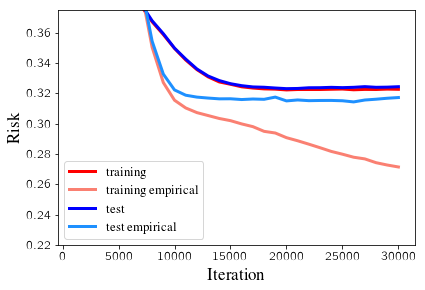

In [28]:
start_plotting()
plt.plot(report_df.iter, (report_df.training_risk),
         label = "training", lw=3, color="red")
plt.plot(report_df.iter, (report_df.training_loss),
         label = "training empirical", lw=3, color="salmon")
plt.plot(report_df.iter, (report_df.test_risk),
         label = "test", lw=3, color="blue")
plt.plot(report_df.iter, (report_df.test_loss),
         label = "test empirical", lw=3, color="dodgerblue")
plt.xlabel("Iteration");
plt.ylabel("Risk")
#plt.xlim(0,10000)
plt.ylim(0.22, 0.375)
plt.legend(); plt.show();

# Numerical optimization performance vs. time 

The results may vary regarding after how many iterations the optimization is performed

In [21]:
# Selects a subset of 10x10 data points and samples y for them
qw = Normal(qw_loc[:,:10], softplus(qw_scale[:,:10]))
qz = Normal(qz_loc[:10,:], softplus(qz_scale[:10,:]))

ys = sample_predictive_y0(qw, qz, 1000, 100)

In [22]:
# Optimization goal:

utility_aggregator = gain
#utility_aggregator = UtilityAggregatorFactory().create("naive")

In [23]:
# Losses and optimal decisions 
tilted_loss, tilted_optimal_h = LossFactory(TILTED_Q=0.2).create("tilted")
tilted_u = lambda h,y: 10000.0-tilted_loss(h,y)
def tilted_optimizer(ys, *args, **kwargs):
    return tilted_optimal_h(flatten_first_two_dims(ys))

if utility_aggregator == gain: tilted_hopt = tilted_optimizer(ys) 
else:                          tilted_hopt = optimal_h_numerically_ty_scipy(
                                    ys, u, utility_aggregator=utility_aggregator, 
                                    debug=False, verbose=True, optimizer="COBYLA")

squared_loss, squared_optimal_h = LossFactory().create("squared")
squared_u = lambda h,y: 10000.0-squared_loss(h,y)
def squared_optimizer(ys, *args, **kwargs):
    return squared_optimal_h(flatten_first_two_dims(ys))

if utility_aggregator == gain: squared_hopt = squared_optimizer(ys) 
else:                          squared_hopt = optimal_h_numerically_ty_scipy(
                                    ys, u, utility_aggregator=utility_aggregator, 
                                    debug=False, verbose=True, optimizer="COBYLA")

[LossFactory] Configuration: TILTED_Q=0.2 LINEX_C=None
[LossFactory] Configuration: TILTED_Q=None LINEX_C=None


In [24]:
def h_times_errors_for_S_samples(Svals, hopt, u, 
                                 utility_aggregator, 
                                 optimizer, 
                                 optimizer_method, 
                                 num_repetitions=4):
    """ Measures time and evaluates MSE for 
        the set Svals of different sample sizes."""
    times, errs = [], []
    for S, Sy in Svals:        
        rtimes, rerrs = [], []
        for r in range(num_repetitions):
            ys = sample_predictive_y0(qw, qz, S, Sy)
            
            start = time.time()
            h = optimizer(ys, u, utility_aggregator=utility_aggregator, 
                          verbose=False, optimizer=optimizer_method)
            elapsed = time.time()-start
            err = ((h-hopt)**2).mean().item()
            
            rtimes.append(elapsed)
            rerrs.append(err)
        times.append(np.mean(rtimes))
        errs.append(np.mean(rerrs))
    return times, errs

In [25]:
Svals = [(2,1),(10,1),(20,1),(30,1),(60,1),(100,1),(500,1),(1000,1),(5000,1)]

u, hopt, analaytical_optimizer = tilted_u, tilted_hopt, tilted_optimizer
times_A, errs_A = h_times_errors_for_S_samples(Svals, hopt, u, utility_aggregator, 
                                               optimal_h_numerically_ty, 
                                               torch.optim.Adam)

u, hopt, analaytical_optimizer = squared_u, squared_hopt, squared_optimizer
times_A_sq, errs_A_sq = h_times_errors_for_S_samples(Svals, hopt, u, utility_aggregator, 
                                               optimal_h_numerically_ty, 
                                               torch.optim.Adam)

[exec no:1][optimal_h_numerically_ty][3.69][ys=(1, 2, 10, 10) max_niter=10000 tol=0.0001 tol_goal=-1 lr=0.01 u=<lambda>->gain] Converged in 10000. iter (max number reached): obj=-999986.5625 max-err=0.00257993 mean-err=0.00081413
[exec no:2][optimal_h_numerically_ty][3.58][ys=(1, 2, 10, 10) max_niter=10000 tol=0.0001 tol_goal=-1 lr=0.01 u=<lambda>->gain] Converged in 10000. iter (max number reached): obj=-999987.2500 max-err=0.00221419 mean-err=0.00073497
[exec no:3][optimal_h_numerically_ty][3.59][ys=(1, 2, 10, 10) max_niter=10000 tol=0.0001 tol_goal=-1 lr=0.01 u=<lambda>->gain] Converged in 10000. iter (max number reached): obj=-999982.6875 max-err=0.00241566 mean-err=0.00082420
[exec no:4][optimal_h_numerically_ty][3.58][ys=(1, 2, 10, 10) max_niter=10000 tol=0.0001 tol_goal=-1 lr=0.01 u=<lambda>->gain] Converged in 10000. iter (max number reached): obj=-999987.1250 max-err=0.00204563 mean-err=0.00068225
[exec no:5][optimal_h_numerically_ty][4.04][ys=(1, 10, 10, 10) max_niter=10000 t

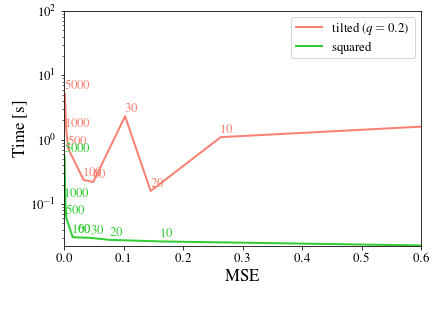

In [26]:
start_plotting(cmbright=False)
formatter = lambda l: str(l[0])
COL1= "limegreen"
COL2= "salmon"
COL3= "dodgerblue"

   
plt.plot(errs_A, times_A, label=r"tilted ($q=0.2$)", color=COL2, lw=2)
for i,j,l in zip(errs_A,times_A,Svals):
    plt.annotate(formatter(l), xy=(i, j*1.2), color=COL2)
    
    
plt.plot(errs_A_sq, times_A_sq, label="squared", color=COL1, lw=2)
for i,j,l in zip(errs_A_sq,times_A_sq,Svals):
    plt.annotate(formatter(l), xy=(i, j*1.2), color=COL1)    
    
plt.xlabel("MSE"); plt.ylabel("Time [s]"); plt.legend(); 
plt.yscale("log"); plt.xlim(0,0.6); plt.ylim(0,100)
plt.show()